##  Transformers for NLP

1. Dataset downloading

In [1]:
!pip install datasets
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

2. Importing all the libraries

In [2]:
import math
import time
import torch
import torch.nn as neuralNet
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import scipy.stats as stats
import matplotlib.font_manager as fm


3. Dataset Loading and Build vocabulary

In [3]:
rawData = load_dataset("tatoeba", lang1="en", lang2="hi", trust_remote_code=True)
pairedData = rawData["train"] if "train" in rawData else rawData


def split_text(sentence):
    return sentence.lower().split()

specialTokens = ['<pad>', '<sos>', '<eos>', '<unk>']

def vocabCreation(pairedData, language):
    distinctWords = set()
    for entry in pairedData:
        text = entry["translation"][language]
        words = split_text(text)
        distinctWords.update(words)
    vocabList = specialTokens + sorted(list(distinctWords))
    word_to_idx = {word: idx for idx, word in enumerate(vocabList)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return word_to_idx, idx_to_word

source_word_to_idx, source_idx_to_word = vocabCreation(pairedData, "en")
target_word_to_idx, target_idx_to_word = vocabCreation(pairedData, "hi")

vocab_size_source = len(source_word_to_idx)
vocab_size_target = len(target_word_to_idx)

IDX_PAD_SOURCE = source_word_to_idx["<pad>"]
IDX_PAD_TARGET = target_word_to_idx["<pad>"]
IDX_SOS_TARGET = target_word_to_idx["<sos>"]
IDX_EOS_TARGET = target_word_to_idx["<eos>"]

def text_to_indices(text, word_to_idx):
    words = split_text(text)
    return [word_to_idx.get(word, word_to_idx["<unk>"]) for word in words]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

tatoeba.py:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

4. Data Analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


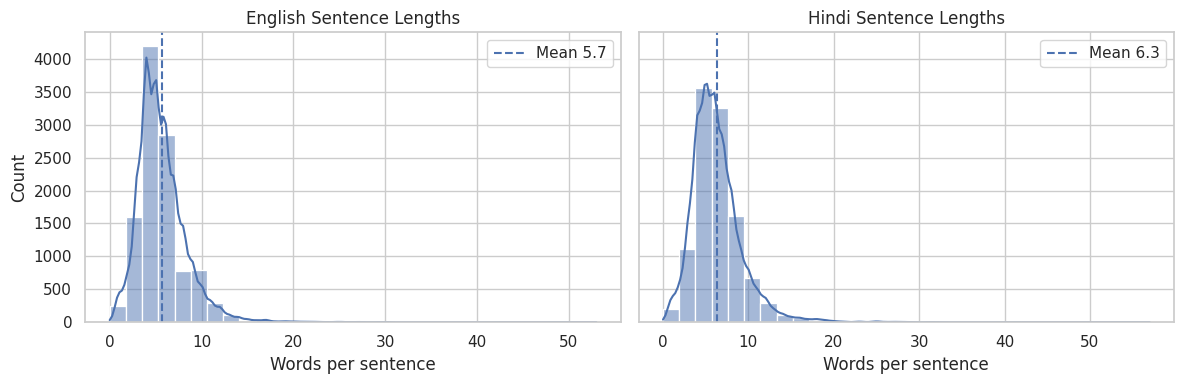

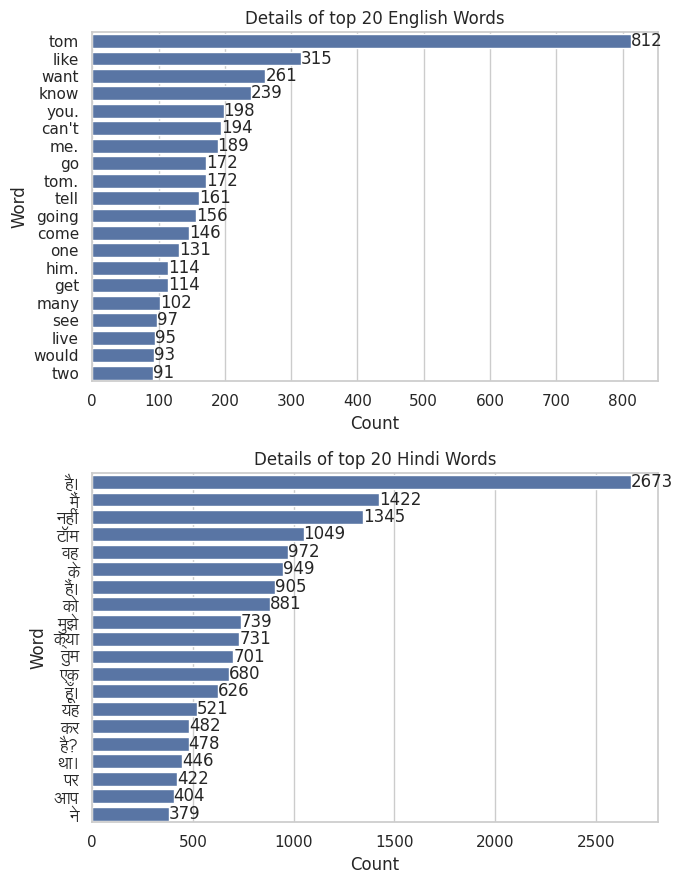

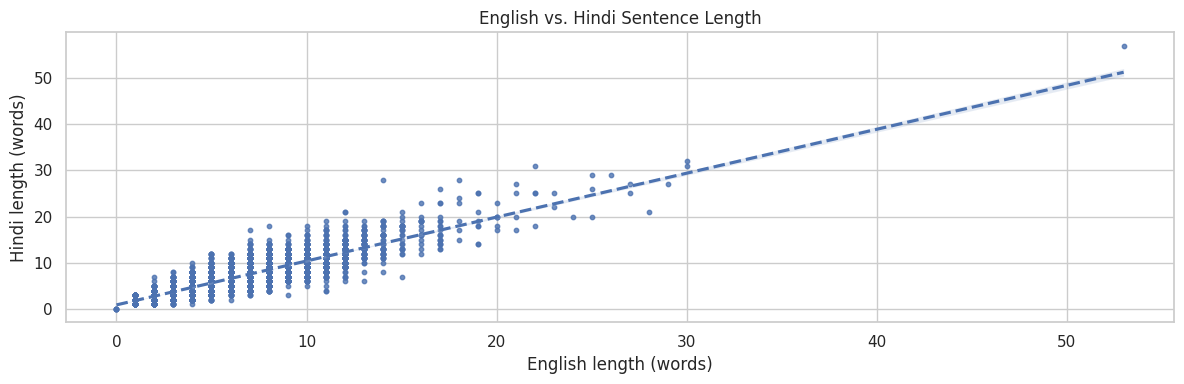

Pearson r = 0.86 (p = 0)


In [6]:
import warnings
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from collections import Counter
import matplotlib.font_manager as fm
import scipy.stats as stats

warnings.filterwarnings("ignore", "Glyph.*missing from font", UserWarning)

nltk.download('stopwords')
stopEn = set(stopwords.words('english'))
stopHi = {"का", "है", "और", "में", "की", "से"}

rawData = load_dataset("tatoeba", lang1="en", lang2="hi", trust_remote_code=True)
dataset = pd.DataFrame(rawData['train'])
dataset['enText'] = dataset['translation'].str['en'].fillna('')
dataset['hiText'] = dataset['translation'].str['hi'].fillna('')

dataset['enLen'] = dataset['enText'].str.split().str.len()
dataset['hiLen'] = dataset['hiText'].str.split().str.len()

englishWords = [
    word.lower()
    for sentence in dataset['enText']
    for word in sentence.split()
    if word.lower() not in stopEn]

hindiWords = [
    word
    for sentence in dataset['hiText']
    for word in sentence.split()
    if word not in stopHi]

topEnglishWords = pd.DataFrame(
    Counter(englishWords).most_common(20),
    columns=['Word', 'Count'])

topHindiWords = pd.DataFrame(
    Counter(hindiWords).most_common(20),
    columns=['Word', 'Count'])

hiFontProperties = fm.FontProperties(fname="Lohit-Devanagari.ttf")

sns.set_theme(style="whitegrid", palette="deep")

figLenDist, axesLenDist = plot.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, col, title in zip(
    axesLenDist,
    ['enLen', 'hiLen'],
    ['English', 'Hindi']
):
    sns.histplot(dataset[col], bins=30, kde=True, ax=ax)
    meanVal = dataset[col].mean()
    ax.axvline(meanVal, linestyle='--', label=f"Mean {meanVal:.1f}")
    ax.set_title(f"{title} Sentence Lengths")
    ax.set_xlabel("Words per sentence")
    ax.legend()
plot.tight_layout()
plot.show()


figWordFreq, (axEnglish, axHindi) = plot.subplots(2, 1, figsize=(7, 9))
sns.barplot(data=topEnglishWords, x='Count', y='Word', ax=axEnglish)
axEnglish.set_title("Details of top 20 English Words")
axEnglish.bar_label(axEnglish.containers[0])

sns.barplot(data=topHindiWords, x='Count', y='Word', ax=axHindi)
axHindi.set_title("Details of top 20 Hindi Words")
for label in axHindi.get_yticklabels():
    txt = label.get_text()
    if any('\u0900' <= ch <= '\u097F' for ch in txt):
        label.set_fontproperties(hiFontProperties)
axHindi.bar_label(axHindi.containers[0])
plot.tight_layout()
plot.show()

figScatterReg, axScatterReg = plot.subplots(figsize=(12, 4))
sns.regplot(
    x='enLen',
    y='hiLen',
    data=dataset,
    scatter_kws={'s': 10},
    line_kws={'linestyle': '--'},
    ax=axScatterReg
)
axScatterReg.set_title("English vs. Hindi Sentence Length")
axScatterReg.set_xlabel("English length (words)")
axScatterReg.set_ylabel("Hindi length (words)")
plot.tight_layout()
plot.show()

pearsonR, pValue = stats.pearsonr(dataset['enLen'], dataset['hiLen'])
print(f"Pearson r = {pearsonR:.2f} (p = {pValue:.3g})")

5. Creating a Custom Dataset Class & Train/Validation Split

In [7]:
class BilingualDataset(Dataset):
    def __init__(self, pairedData, source_word_to_idx, target_word_to_idx, max_length=50):
        self.pairedData = pairedData
        self.source_word_to_idx = source_word_to_idx
        self.target_word_to_idx = target_word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.pairedData)

    def __getitem__(self, idx):
        entry = self.pairedData[idx]
        textSource = entry["translation"]["en"]
        textTarget = entry["translation"]["hi"]

        sourceTokens = text_to_indices(textSource, self.source_word_to_idx)
        targetTokens = [IDX_SOS_TARGET] + text_to_indices(textTarget, self.target_word_to_idx) + [IDX_EOS_TARGET]

        sourceTokens = sourceTokens[:self.max_length] + [IDX_PAD_SOURCE] * (self.max_length - len(sourceTokens))
        targetTokens = targetTokens[:self.max_length] + [IDX_PAD_TARGET] * (self.max_length - len(targetTokens))

        return torch.tensor(sourceTokens, dtype=torch.long), torch.tensor(targetTokens, dtype=torch.long)

dataSplit = pairedData.train_test_split(test_size=0.1)
max_length = 60
train_data = BilingualDataset(dataSplit['train'], source_word_to_idx, target_word_to_idx, max_length=max_length)
validation_data = BilingualDataset(dataSplit['test'], source_word_to_idx, target_word_to_idx, max_length=max_length)

trainLoader = DataLoader(train_data, batch_size=32, shuffle=True)
valLoader = DataLoader(validation_data, batch_size=32, shuffle=False)

6. Define Positional Encoding

In [8]:
class PositionEmbedding(neuralNet.Module):
    def __init__(self, model_dim, dropout_rate=0.2, max_len=5000):
        super().__init__()
        self.dropout = neuralNet.Dropout(p=dropout_rate)
        pos_embed = torch.zeros(max_len, model_dim)
        pos_index = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_factor = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        pos_embed[:, 0::2] = torch.sin(pos_index * div_factor)
        pos_embed[:, 1::2] = torch.cos(pos_index * div_factor)
        pos_embed = pos_embed.unsqueeze(0)
        self.register_buffer("pos_embed", pos_embed)

    def forward(self, xVar):
        xVar = xVar + self.pos_embed[:, :xVar.size(1)]
        return self.dropout(xVar)

7. Define Transformer Model

In [9]:
class TransformerModel(neuralNet.Module):
    def __init__(self, encoder_layers, decoder_layers, embedding_dim,
                 attention_heads, source_vocab_size, target_vocab_size, feedforward_dim=512, dropout_rate=0.1):
        super().__init__()
        self.transformer = neuralNet.Transformer(d_model=embedding_dim, nhead=attention_heads,
                                          num_encoder_layers=encoder_layers,
                                          num_decoder_layers=decoder_layers,
                                          dim_feedforward=feedforward_dim, dropout=dropout_rate)

        self.output_layer = neuralNet.Linear(embedding_dim, target_vocab_size)
        self.source_embedding = neuralNet.Embedding(source_vocab_size, embedding_dim)
        self.target_embedding = neuralNet.Embedding(target_vocab_size, embedding_dim)
        self.positional_encoding = PositionEmbedding(embedding_dim, dropout_rate=dropout_rate)

    def forward(self, src, tgt, src_mask, tgt_mask, src_pad_mask, tgt_pad_mask, memory_pad_mask):
        embedSource = self.positional_encoding(self.source_embedding(src))
        embedTarget = self.positional_encoding(self.target_embedding(tgt))
        memory = self.transformer.encoder(embedSource.transpose(0, 1), src_key_padding_mask=src_pad_mask)
        output = self.transformer.decoder(embedTarget.transpose(0, 1), memory, tgt_mask=tgt_mask,
                                          tgt_key_padding_mask=tgt_pad_mask,
                                          memory_key_padding_mask=memory_pad_mask)
        return self.output_layer(output.transpose(0, 1))

8. Helper Functions for Masks

In [10]:
import torch
from typing import Tuple

def creatingMask(size: int, device: torch.device = None) -> torch.BoolTensor:
    device = device or torch.device('cpu')
    return torch.triu(torch.ones((size, size), device=device), diagonal=1).bool()

def preparingMaks(
    src: torch.Tensor,
    tgt: torch.Tensor,
    srcPadIdx: int,
    tgtPadIdx: int,
    device: torch.device = None
) -> Tuple[torch.BoolTensor, torch.BoolTensor, torch.BoolTensor, torch.BoolTensor]:
    device = device or src.device
    _, srcLen = src.shape
    _, tgtLen = tgt.shape
    srcMask = torch.zeros((srcLen, srcLen), device=device, dtype=torch.bool)
    tgtMask = creatingMask(tgtLen, device=device)
    srcPadMask = src.eq(srcPadIdx)
    tgtPadMask = tgt.eq(tgtPadIdx)
    return srcMask, tgtMask, srcPadMask, tgtPadMask

9. Initialize Model, Loss, and Optimizer

In [11]:
ENCODER_LAYERS = 3
DECODER_LAYERS = 3
EMBEDDING_DIM = 256
NUM_HEADS = 8
FEEDFORWARD_DIM = 512
DROPOUT_RATE = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModel(
    ENCODER_LAYERS, DECODER_LAYERS, EMBEDDING_DIM, NUM_HEADS,
    vocab_size_source, vocab_size_target, FEEDFORWARD_DIM, DROPOUT_RATE
).to(device)

lossFunction = neuralNet.CrossEntropyLoss(ignore_index=IDX_PAD_TARGET)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


10. Training & Evaluation Loops

In [12]:
import time
import math
import torch
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def trainAndEvaluate(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    lossFunction,
    trainLoader,
    valLoader,
    device: torch.device = None,
    numEpochs: int = 20
):
    device = device or torch.device('cpu')
    scaler = GradScaler(device.type)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

    def calculateAccuracy(logits, target, padIdx):
        preds = logits.argmax(dim=-1)
        mask  = target.ne(padIdx)
        return (preds == target).masked_select(mask).sum().item(), mask.sum().item()

    for epoch in range(1, numEpochs + 1):
        startTime = time.time()
        model.train()
        trainLoss = trainCorrect = trainTokens = 0

        for batch in trainLoader:
            try:
                srcBatch, tgtBatch = batch
            except:
                continue

            srcBatch, tgtBatch = srcBatch.to(device), tgtBatch.to(device)
            srcInput, tgtOutput = tgtBatch[:, :-1], tgtBatch[:, 1:]
            srcMask, tgtMask, srcPadMask, tgtPadMask = preparingMaks(
                srcBatch, srcInput, IDX_PAD_SOURCE, IDX_PAD_TARGET, device=device
            )

            optimizer.zero_grad()
            with autocast(device.type):
                logits = model(srcBatch, srcInput, srcMask, tgtMask, srcPadMask, tgtPadMask, srcPadMask)
                loss   = lossFunction(
                    logits.reshape(-1, logits.size(-1)),
                    tgtOutput.reshape(-1)
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            trainLoss   += loss.item()
            c, t         = calculateAccuracy(logits, tgtOutput, IDX_PAD_TARGET)
            trainCorrect += c
            trainTokens  += t

        avgTrainLoss = trainLoss / len(trainLoader)
        trainPPL     = math.exp(avgTrainLoss)
        trainAcc     = trainCorrect / trainTokens if trainTokens else 0

        model.eval()
        valLoss = valCorrect = valTokens = 0
        if valLoader:
            with torch.no_grad():
                for batch in valLoader:
                    try:
                        srcBatch, tgtBatch = batch
                    except:
                        continue

                    srcBatch, tgtBatch = srcBatch.to(device), tgtBatch.to(device)
                    srcInput, tgtOutput = tgtBatch[:, :-1], tgtBatch[:, 1:]
                    srcMask, tgtMask, srcPadMask, tgtPadMask = preparingMaks(
                        srcBatch, srcInput, IDX_PAD_SOURCE, IDX_PAD_TARGET, device=device
                    )

                    logits = model(srcBatch, srcInput, srcMask, tgtMask, srcPadMask, tgtPadMask, srcPadMask)
                    loss   = lossFunction(
                        logits.reshape(-1, logits.size(-1)),
                        tgtOutput.reshape(-1)
                    )

                    valLoss    += loss.item()
                    c, t        = calculateAccuracy(logits, tgtOutput, IDX_PAD_TARGET)
                    valCorrect += c
                    valTokens  += t

        avgValLoss = valLoss / len(valLoader) if valLoader else 0
        valPPL     = math.exp(avgValLoss) if avgValLoss < 100 else float('inf')
        valAcc     = valCorrect / valTokens if valTokens else 0

        scheduler.step(avgValLoss)
        elapsedTime = time.time() - startTime

        print(
            f"Epoch {epoch:2d} | "
            f"Train Loss: {avgTrainLoss:.4f}, PPL: {trainPPL:.2f}, Acc: {trainAcc*100:5.2f}% | "
            f"Val   Loss: {avgValLoss:.4f}, PPL: {valPPL:.2f}, Acc: {valAcc*100:5.2f}% | "
            f"Time: {elapsedTime:.1f}s"
        )

NUM_EPOCHS = 20
trainAndEvaluate(model, optimizer, lossFunction, trainLoader, valLoader, device, NUM_EPOCHS)

Epoch  1 | Train Loss: 6.5242, PPL: 681.45, Acc: 15.48% | Val   Loss: 5.8344, PPL: 341.86, Acc: 19.07% | Time: 13.6s
Epoch  2 | Train Loss: 5.6493, PPL: 284.08, Acc: 20.58% | Val   Loss: 5.5640, PPL: 260.87, Acc: 21.93% | Time: 10.8s
Epoch  3 | Train Loss: 5.3785, PPL: 216.71, Acc: 22.79% | Val   Loss: 5.3541, PPL: 211.47, Acc: 24.83% | Time: 17.9s
Epoch  4 | Train Loss: 5.1760, PPL: 176.97, Acc: 24.58% | Val   Loss: 5.1846, PPL: 178.50, Acc: 26.98% | Time: 14.9s
Epoch  5 | Train Loss: 5.0062, PPL: 149.33, Acc: 26.07% | Val   Loss: 5.0622, PPL: 157.93, Acc: 28.25% | Time: 10.9s
Epoch  6 | Train Loss: 4.8490, PPL: 127.61, Acc: 27.32% | Val   Loss: 4.9617, PPL: 142.83, Acc: 29.24% | Time: 11.1s
Epoch  7 | Train Loss: 4.7027, PPL: 110.24, Acc: 28.54% | Val   Loss: 4.8481, PPL: 127.50, Acc: 30.63% | Time: 10.9s
Epoch  8 | Train Loss: 4.5725, PPL: 96.79, Acc: 29.56% | Val   Loss: 4.7859, PPL: 119.80, Acc: 31.18% | Time: 10.9s
Epoch  9 | Train Loss: 4.4507, PPL: 85.69, Acc: 30.51% | Val   Lo

11. Inference and testing

In [16]:
def translatingText(model, input_text, source_word_to_idx, target_idx_to_word, max_length=50):

    model.eval()

    tokenIndices = text_to_indices(input_text, source_word_to_idx)
    tokenIndices = tokenIndices[:max_length]
    tensorSource = torch.tensor(tokenIndices, dtype=torch.long).unsqueeze(0).to(device)

    src_mask = torch.zeros((tensorSource.shape[1], tensorSource.shape[1]), device=device).type(torch.bool)

    outputMemory = model.transformer.encoder(
        model.positional_encoding(model.source_embedding(tensorSource)).transpose(0, 1),
        src_key_padding_mask=(tensorSource == IDX_PAD_SOURCE)
    )

    translated_tokens = torch.tensor([[IDX_SOS_TARGET]], dtype=torch.long).to(device)

    for _ in range(max_length - 1):
        tgt_mask = creatingMask(translated_tokens.size(1)).to(device)
        output = model.transformer.decoder(
            model.positional_encoding(model.target_embedding(translated_tokens)).transpose(0, 1),
            outputMemory,
            tgt_mask=tgt_mask
        )
        output = model.output_layer(output.transpose(0, 1))


        nextWord = output[:, -1, :].argmax(dim=-1).item()
        translated_tokens = torch.cat([translated_tokens, torch.tensor([[nextWord]], dtype=torch.long).to(device)], dim=1)

        if nextWord == IDX_EOS_TARGET:
            break

    final_translation = [target_idx_to_word[idx] for idx in translated_tokens.squeeze().tolist()]
    final_translation = final_translation[1:]
    if '<eos>' in final_translation:
        final_translation = final_translation[:final_translation.index('<eos>')]

    return " ".join(final_translation)

In [30]:

input_sentence = "book"
translated_sentence = translatingText(model, input_sentence, source_word_to_idx, target_idx_to_word)
print("Translated Sentence is given as:", translated_sentence)


Translated Sentence is given as: यह किताब


In [31]:

input_sentence = "What is your name?"
translated_sentence = translatingText(model, input_sentence, source_word_to_idx, target_idx_to_word)
print("Translated Sentence is given as:", translated_sentence)


Translated Sentence is given as: तुम्हारा नाम क्या है?


In [34]:
input_sentence = "its beautiful"
translated_sentence = translatingText(model, input_sentence, source_word_to_idx, target_idx_to_word)
print("Translated Sentence is given as:", translated_sentence)

Translated Sentence is given as: वह बहुत सुंदर है।
